# Milestone 1 Phase 2
- Muhammad Fadlil Ismail
- FTDS Batch 10

## 1. Pendahuluan

### a. Objective
Milestones 1 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

    1. Mampu memahami konsep Artificial Neural Network.
    2. Mampu mempersiapkan data untuk digunakan dalam model Artificial Neural Network.
    3. Mampu mengimplementasikan Artificial Neural Network dengan data yang diberikan.
    4. Mampu menganalisis dan menjelaskan layer yang dibuat.

### b. Tentang Dataset
Context

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

    Customers who left within the last month – the column is called Churn
    Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    Demographic info about customers – gender, age range, and if they have partners and dependents


## 2. Import Library

In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation
import warnings
warnings.filterwarnings("ignore")

## 3. Load Data

In [268]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Cek bentuk dataset

In [269]:
df.shape

(7043, 21)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Dataset terdiri dari 7043 baris, 21 kolom. Dimana terdapat 3 kolom yang menyimpan data numerik dan 18 kolom yang menyimpan data string.

### Cek statistik

In [271]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Cek missing value

In [272]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Tidak terdapat missing value di semua kolom dataset.

## 4. Exploratory Data Analysis

### Lihat distribusi target
Target pada dataset ini adalah kolom Churn

In [273]:
df.Churn.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

<AxesSubplot:>

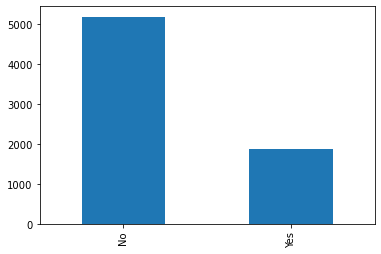

In [274]:
df.Churn.value_counts().plot(kind='bar')

Jumlah customer yang 'churn' (nilai kolom Churn = Yes) lebih sedikit dibandingkan jumlah customer yang tidak 'churn'.

### Drop kolom customerID
Kolom customerID memiliki cardinality yang sangat tinggi karena merupakan unique value untuk tiap-tiap customer.

In [275]:
df.drop('customerID', axis=1, inplace=True)

### Ubah format kolom
Kolom TotalCharges berisi data numerik, namun pada df.info() terlihat formatnya object sehingga perlu diubah ke numerik.

In [276]:
hasil = []
for i in df['TotalCharges']:
    try:
        a = float(i)
        hasil.append(a)
    except:
        hasil.append(a)
df['TotalCharges'] = hasil

In [277]:
df['TotalCharges'].mean()

2285.169963083916

### Pisahkan kolom numerik dan kategorik
Hal ini perlu dilakukan untuk memudahkan analisis berikutnya.

In [278]:
num_col = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_col = df.columns.tolist()
cat_col.remove('tenure')
cat_col.remove('MonthlyCharges')
cat_col.remove('TotalCharges')

### Analisa pada kolom numerik

Berikut rata-rata value pada kolom numerik untuk tiap-tiap kelas target:

In [279]:
df.groupby('Churn').mean()[num_col]

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2557.310620
Yes,17.979133,74.441332,1531.796094


Terdapat perbedaan rata-rata yang cukup jauh untuk value pada kelas Yes dan No, baik pada kolom tenure, TotalCharges maupun kolom MonthlyCharges. Pada proses selanjutnya akan dilakukan two sample two tailed t-test untuk mengonfirmasi perbedaan ini. Adapun distribusi untuk kolom numerik berdasarkan tiap-tiap kelas target adalah sebagai berikut :

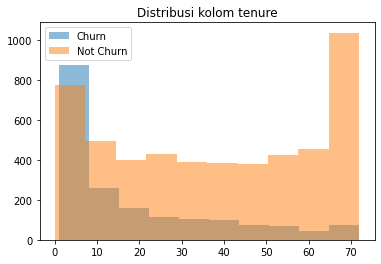

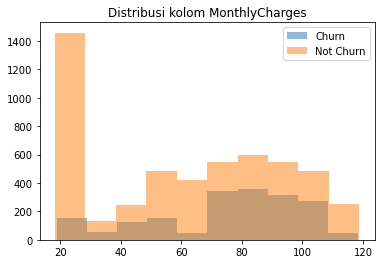

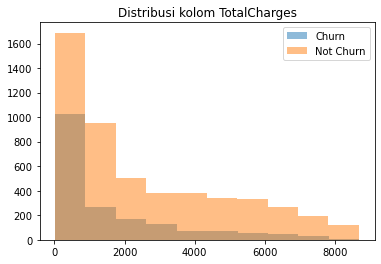

In [280]:
for i in num_col:
    a = df[df.Churn=='Yes'][i]
    b = df[df.Churn=='No'][i]
    plt.hist(a, alpha=0.5, label='Churn')
    plt.hist(b, alpha=0.5, label='Not Churn')
    plt.title('Distribusi kolom '+ i)
    plt.legend()
    plt.show()

Dari histogram di atas bisa disimpulkan bahwa :
1. Pada kolom tenure terlihat bahwa mayoritas customer yang churn memiliki tenure yang pendek, adapun customer yang tidak churn mayoritas memiliki tenure yang panjang walaupun banyak juga yang memiliki tenure pendek.
2. Pada kolom MonthlyCharges, customer yang tidak churn mayoritas memiliki MonthlyCharges yang rendah, adapun customer yang churn mayoritas memiliki MonthlyCharges yang tinggi.
3. Terlihat distribusi yang mirip pada kolom TotalCharges baik untuk customer yang churn maupun tidak.

Hubungan antar tiap-tiap kolom numerik menggunakan heatmap adalah sebagai berikut :

<AxesSubplot:>

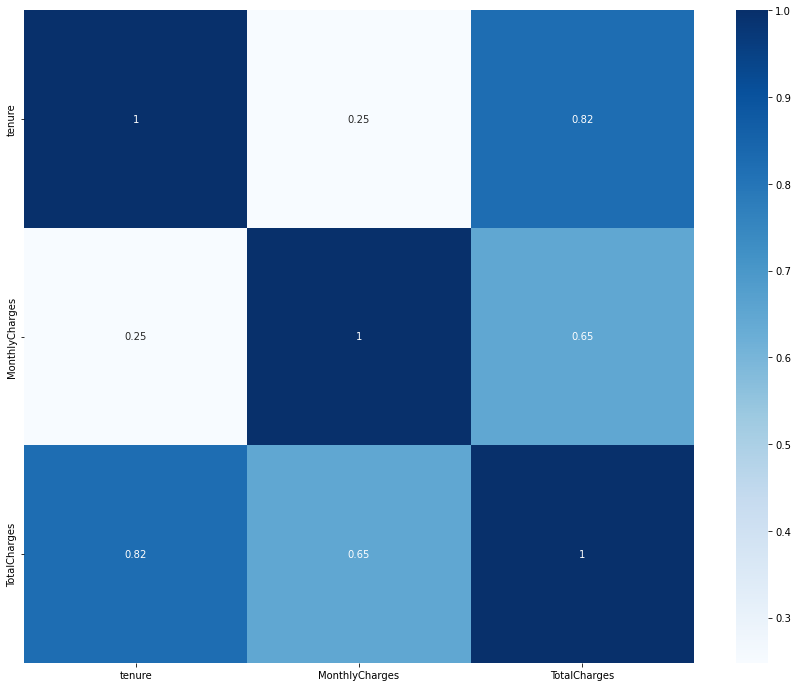

In [281]:
corr1 = df[num_col].corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr1,cmap='Blues',annot=True)

Terlihat nilai korelasi >0.5 untuk pasangan kolom :
1. tenure dan TotalCharges, dengan korelasi sebesar 0.82.
2. MonthlyCharges dan TotalCharges, dengan korelasi sebesar 0.65.

### Analisa pada kolom kategorik

Lihat hubungan tiap-tiap kategorik dengan tiap-tiap kelas target dengan bantuan visualisasi:

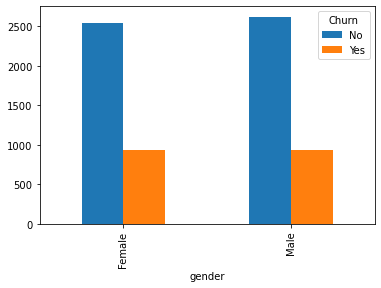

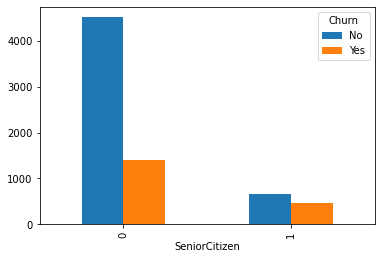

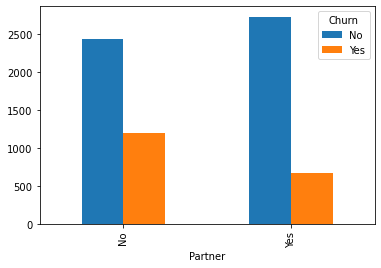

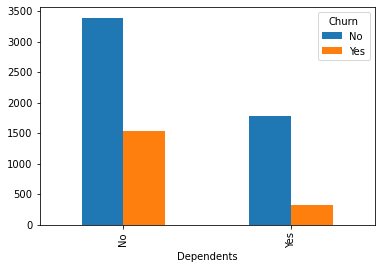

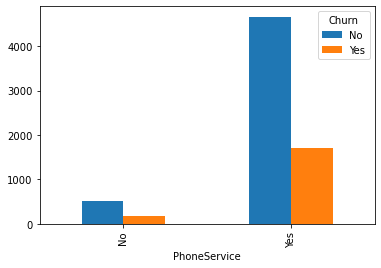

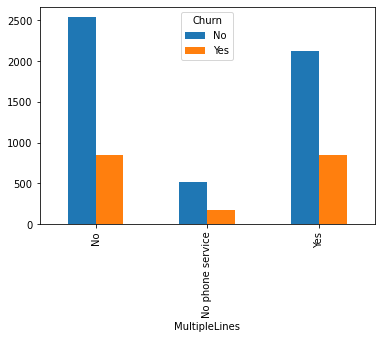

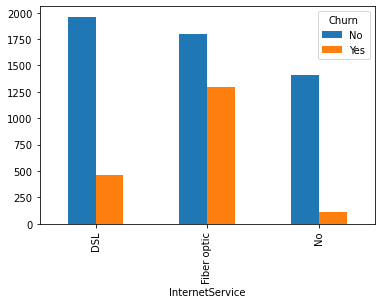

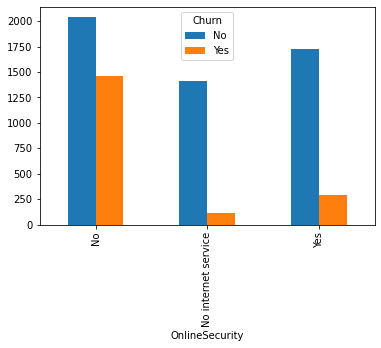

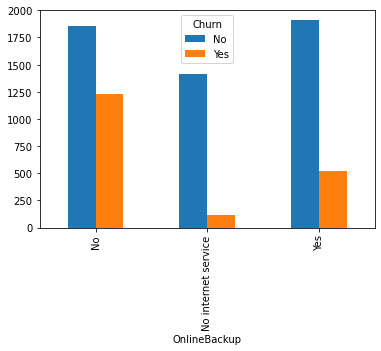

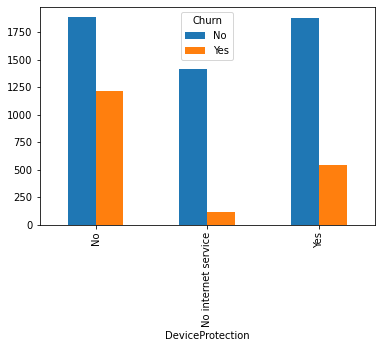

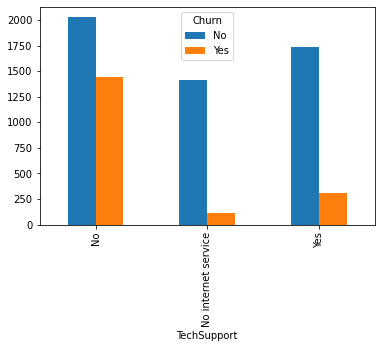

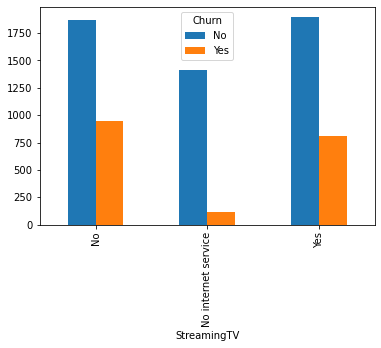

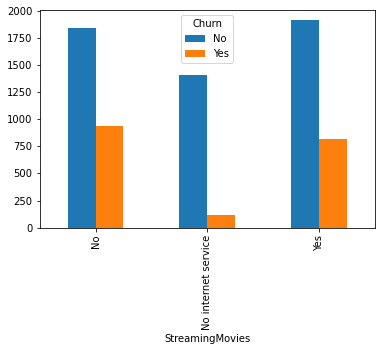

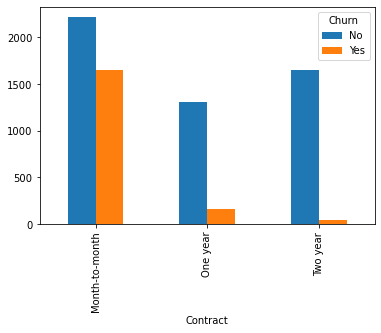

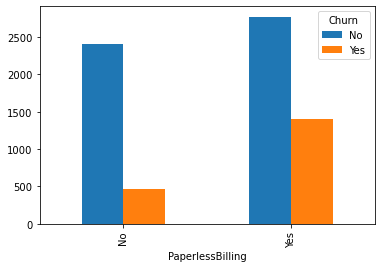

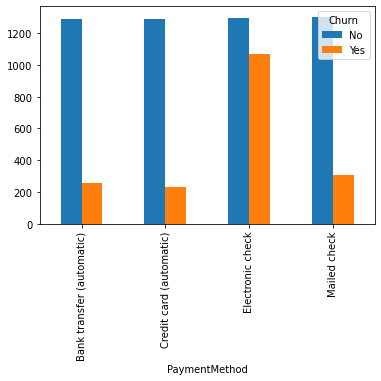

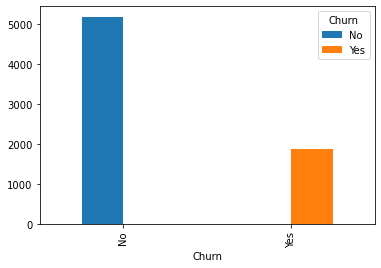

In [282]:
for i in cat_col:
    pd.crosstab(df[i], df['Churn']).plot(kind='bar')
    plt.show()

Terlihat churn rate yang tinggi untuk customer dengan :
1. Senior Citizen = 1
2. InternetService = Fiber Optic
3. OnlineSecurity = No
4. OnlineBackup = No
5. DeviceProtection  = No
6. TechSupport = No
7. Contract = Month to month
8. PaymentMethod = Electronic check

## 5. Data Preprocessing

### a. Data Inference

In [283]:
#Ambil inference
df_inf = df.sample(5, random_state=69)

#Pisahkan inference dari semua data
df_train_test = df.drop(df_inf.index)

#Reset index
df_train_test.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)

Diambil data inference secara random sebanyak 5 data.

### b. Split Feature (X) dan Target (y)

In [284]:
X = df_train_test.drop('Churn', axis=1)
y = df_train_test['Churn']

kolom target adalah kolom Churn, sedangkan feature adalah kolom selain kolom tersebut.

### c. Split Data Train, Data Validation dan Data Test

Split data train_val dengan data test:

In [285]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=69)

Split data train dengan data val:

In [286]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=69)

Cek dimensi:

In [287]:
#Reset index
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

#Cek dimensi
print(f'dimensi x-train: {X_train.shape}')
print(f'dimensi x-train: {X_val.shape}')
print(f'dimensi x-test : {X_test.shape}')
print(f'dimensi y-train: {y_train.shape}')
print(f'dimensi y-train: {y_val.shape}')
print(f'dimensi y-test : {y_test.shape}')

dimensi x-train: (5383, 19)
dimensi x-train: (599, 19)
dimensi x-test : (1056, 19)
dimensi y-train: (5383,)
dimensi y-train: (599,)
dimensi y-test : (1056,)


Dimensi data train, val dan test sudah sesuai.

### d. Handling Outlier
Cek skewness untuk tiap-tiap kolom numerik:

In [288]:
#Cek Skewness
skew = []
for i in num_col:
    skew.append(abs(X_train[i].skew()))

Tampilkan hasilnya dalam dataframe:

In [289]:
df_skew = pd.DataFrame({'Kolom':num_col, 'Skewness_abs':skew})
df_skew['normal'] = df_skew.Skewness_abs.apply(lambda x: True if x<=0.5 else False)
df_skew

,Kolom,Skewness_abs,normal
0,tenure,0.230185,True
1,MonthlyCharges,0.223690,True
2,TotalCharges,0.939295,False


Buat list berisi kolom terdistribusi normal dan kolom tidak terdistribusi normal:

In [290]:
skew_col = list(df_skew[df_skew.normal==False]['Kolom'])
normal_col = list(df_skew[df_skew.normal==True]['Kolom'])

Lakukan pengecekan jumlah outlier pada kolom yang tidak terdistribusi normal dan tampilkan hasilnya ke dalam dataframe:

In [291]:
jumlah_outliers = []
percent_outliers = []
lower1_lst = []
upper1_lst = []
for i in skew_col:
    num = 3
    q1 = np.nanquantile(X_train[i], 0.25)
    q3 = np.nanquantile(X_train[i], 0.75)
    iqr = q3 - q1
    upper1 = q3 + num*iqr
    lower1 = q1 - num*iqr
    upper1_lst.append(upper1)
    lower1_lst.append(lower1)
    jumlah = len(X_train[(X_train[i]>upper1)|(X_train[i]<lower1)])
    jumlah_outliers.append(jumlah)
    percent = len(X_train[(X_train[i]>upper1)|(X_train[i]<lower1)])*100/len(X_train)
    percent_outliers.append(percent)

In [292]:
pd.DataFrame({'kolom':skew_col, 'jumlah_outlier':jumlah_outliers, 'persen_outlier':percent_outliers, 'upper': upper1_lst, 'lower': lower1_lst})

,kolom,jumlah_outlier,persen_outlier,upper,lower
0,TotalCharges,0,0.0,14214.45,-9959.7


Tidak terdapat outlier pada kolom yang tidak terdistribusi normal.

Lakukan pengecekan jumlah outlier pada kolom yang terdistribusi normal dan tampilkan hasilnya ke dalam dataframe:

In [293]:
percent_outliers1 = []
jumlah_outliers1 = []
upper_lst = []
lower_lst = []
for i in normal_col:
    std = X_train[i].std()
    upper = X_train[i].mean() + 3*std
    lower = X_train[i].mean() - 3*std
    upper_lst.append(upper)
    lower_lst.append(lower)
    jumlah = len(X_train[(X_train[i]>upper)|(X_train[i]<lower)])
    jumlah_outliers1.append(jumlah)
    percent = len(X_train[(X_train[i]>upper)|(X_train[i]<lower)])*100/len(X_train)
    percent_outliers1.append(percent)

In [294]:
pd.DataFrame({'kolom':normal_col, 'jumlah_outlier':jumlah_outliers1, 'persen_outlier':percent_outliers1, 'upper':upper_lst, 'lower':lower_lst})

,kolom,jumlah_outlier,persen_outlier,upper,lower
0,tenure,0,0.0,106.597294,-41.464840
1,MonthlyCharges,0,0.0,155.263913,-25.519347


Tidak terdapat outlier pada kolom yang terdistribusi normal. Karena tidak terdapat outlier pada semua kolom, maka tidak dilakukan handling outlier.

### e. Handling Missing Value

Cek missing value pada data train, data val dan data test:

In [295]:
X_train.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [296]:
X_val.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [297]:
X_test.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Tidak terdapat missing value pada data train, data val dan data test, sehingga tidak perlu dilakukan handling outlier.

### f. Feature Selection

#### Kolom kategorik

Pada kolom kategorik, dilakukan chi square test untuk menentukan apakah kolom tersebut berhubungan dengan kolom target atau tidak. Apabila nilai p-value dari chi square test lebih besar dari 0.05 maka kolom tersebut tidak berhubungan dengan target sehingga dapat di-drop.

In [298]:
cat_col.remove('Churn')

Hitung p-value untuk tiap-tiap kolom :

In [299]:
pval1 = []
for i in cat_col:
    xtab = pd.crosstab(y_train, X_train[i])
    chi2, p, dof, ex = stats.chi2_contingency(xtab)
    pval1.append(p)
a = pd.DataFrame({'Kolom':cat_col, 'p-value':pval1})
a['drop'] = a['p-value']>0.05
a

,Kolom,p-value,drop
0,gender,3.320848e-01,True
1,SeniorCitizen,1.437889e-29,False
2,Partner,4.600274e-29,False
3,Dependents,3.416345e-33,False
4,PhoneService,2.249733e-01,True
5,MultipleLines,3.517035e-02,False
6,InternetService,1.218140e-118,False
7,OnlineSecurity,8.839157e-136,False
8,OnlineBackup,1.228702e-102,False
9,DeviceProtection,1.380227e-93,False


Kolom gender dan PhoneService memiliki pvalue > 0.05.

#### Kolom numerik

Pada kolom numerik, dilakukan two sample two tailed t-test untuk menentukan apakah ada perbedaan rata-rata yang signifikan antara value pada target Churn='Yes' dan target Churn='No' untuk tiap-tiap kolom numerik. Apabila nilai p-value dari two sample two tailed t-test lebih besar dari 0.05 maka kolom tersebut tidak berhubungan dengan target sehingga dapat di-drop.

In [300]:
pval2 = []
for i in num_col:
    a = X_train[y_train=='Yes'][i]
    b = X_train[y_train=='No'][i]
    tstat, pval = stats.ttest_ind(a,b)
    pval2.append(pval)
b = pd.DataFrame({'Kolom':num_col, 'p-value':pval2})
b['drop'] = b['p-value']>0.05
b

,Kolom,p-value,drop
0,tenure,5.040061e-156,False
1,MonthlyCharges,2.365611e-44,False
2,TotalCharges,7.686341e-51,False


Tidak terdapat kolom numerik dengan pvalue > 0.05, selanjutnya akan dilakukan pengecekan korelasi antar feature :

<AxesSubplot:>

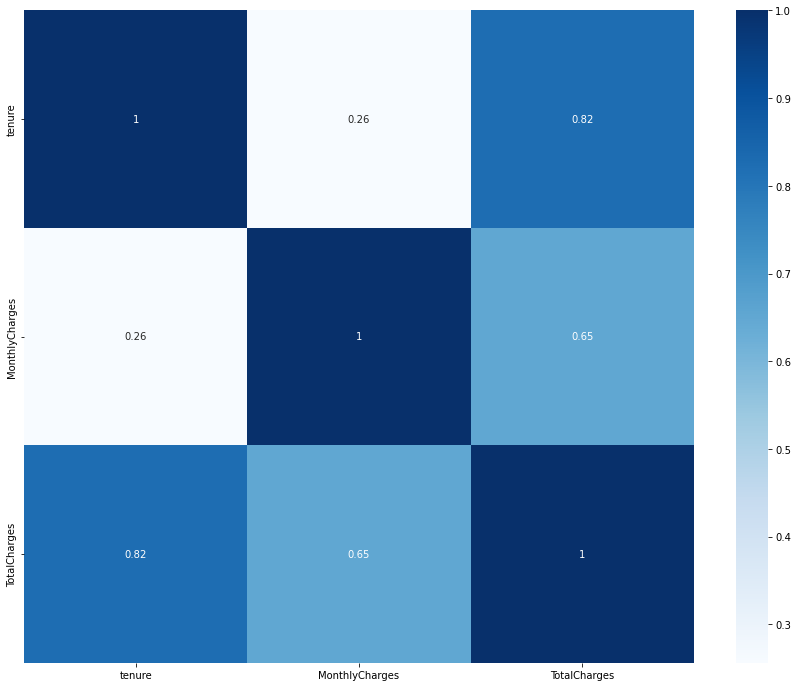

In [301]:
corr1 = X_train[num_col].corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr1,cmap='Blues',annot=True)

Dari heatmap terlihat bahwa:
1. Kolom TotalCharges dan tenure memiliki korelasi 0.82.
2. Kolom TotalCharges dan MonthlyCharges memiliki korelasi 0.65.
3. Kolom MonthlyCharges dan tenure memiliki korelasi 0.26.

Kolom TotalCharges memiliki korelasi lebih dari 0.5 terhadap dua kolom sehingga diputuskan kolom ini didrop.
Kolom-kolom yang di-drop adalah:
1. gender
2. PhoneService
3. TotalCharges

Lakukan drop terhadap ketiga kolom tersebut terhadap X_train, X_val dan X_test :

In [302]:
X_train.drop(['gender', 'PhoneService', 'TotalCharges'], axis=1, inplace=True)
X_val.drop(['gender', 'PhoneService', 'TotalCharges'], axis=1, inplace=True)
X_test.drop(['gender', 'PhoneService', 'TotalCharges'], axis=1, inplace=True)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5383, 16)
(599, 16)
(1056, 16)


Dimensi X_train, X_val, X_test setelah ketiga kolom di-drop sudah sesuai.

### g. Pisahkan kolom numerik dan kategorik


In [303]:
num_col_fix = ['tenure', 'MonthlyCharges']
ohe_col_fix = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
le_col_fix = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling']

In [307]:
X_train_num = X_train[num_col_fix]
X_val_num = X_val[num_col_fix]
X_test_num = X_test[num_col_fix]

X_train_ohe = X_train[ohe_col_fix]
X_val_ohe = X_val[ohe_col_fix]
X_test_ohe = X_test[ohe_col_fix]

X_train_le = X_train[le_col_fix]
X_val_le = X_val[le_col_fix]
X_test_le = X_test[le_col_fix]

### h. Feature Scaling
Akan dilakukan scaling terhadap kolom numerik menggunakan StandardScaler sebagai berikut:

In [308]:
#Definisikan scaler
scaler = StandardScaler()

#scaling data train, val dan test
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

Cek dimensi hasil scaling :

In [309]:
print(X_train_num_scaled.shape)
print(X_val_num_scaled.shape)
print(X_test_num_scaled.shape)

(5383, 2)
(599, 2)
(1056, 2)


Dimensi hasil scaling untuk kolom numerik sudah sesuai.

### i. Label Encoding
Lakukan encoding terhadap target (y_train, y_val dan y_test), dimana Yes = 1 dan No = 0 :

In [310]:
y_train = y_train.map({'Yes':1, 'No':0})
y_val = y_val.map({'Yes':1, 'No':0})
y_test = y_test.map({'Yes':1, 'No':0})

Pada kolom SeniorCitizen, nilai 1 berarti pelanggan yang sudah tua, 0 berarti pelanggan yang masih muda. Karena semua kolom kategorik akan di OneHotEncoding, maka nilai 1 pada kolom tersebut diganti dengan Yes dan 0 diganti dengan No.

In [311]:
X_train_le['SeniorCitizen'] = X_train_le.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')
X_val_le['SeniorCitizen'] = X_val_le.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')
X_test_le['SeniorCitizen'] = X_test_le.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

Lakukan OneHotEncoding

In [312]:
encoder = OneHotEncoder(sparse=False)
X_train_ohe_enc = encoder.fit_transform(X_train_ohe)
X_val_ohe_enc = encoder.transform(X_val_ohe)
X_test_ohe_enc = encoder.transform(X_test_ohe)

Cek dimensi hasil encoding:

In [314]:
print(X_train_ohe_enc.shape)
print(X_val_ohe_enc.shape)
print(X_test_ohe_enc.shape)

(5383, 31)
(599, 31)
(1056, 31)


Dimensi setelah one hot encoding telah sesuai. Lakukan OrdinalEncoder untuk kolom yang lain:

In [317]:
ordencoder = OrdinalEncoder()
ordencoder.fit(X_train_le)
X_train_le_enc = ordencoder.transform(X_train_le)
X_val_le_enc = ordencoder.transform(X_val_le)
X_test_le_enc = ordencoder.transform(X_test_le)

Cek dimensi hasil label encoder:

In [320]:
print(X_train_le_enc.shape)
print(X_val_le_enc.shape)
print(X_test_le_enc.shape)

(5383, 4)
(599, 4)
(1056, 4)


Dimensi hasil label encoder telah sesuai.

### j. Pipeline Preprocessing
Akan dibuat pipeline sesuai dari langkah pada data preprocessing.

In [321]:
prep_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_col_fix),
    ('le', OrdinalEncoder(), le_col_fix),
    ('cat', OneHotEncoder(sparse=False), ohe_col_fix)
])

Pipeline akan diujicoba pada data train, val dan test sehingga perlu penyesuaian terlebih dahulu yaitu inputasi Yes/No untuk kolom SeniorCitizen.

In [322]:
X_train['SeniorCitizen'] = X_train.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')
X_val['SeniorCitizen'] = X_val.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')
X_test['SeniorCitizen'] = X_test.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

Lakukan training pipeline preprocessing terhadap X_train, gunakan untuk mentransform X_train, X_val dan X_test.

In [323]:
prep_pipeline.fit(X_train)
X_train_final = prep_pipeline.transform(X_train)
X_val_final = prep_pipeline.transform(X_val)
X_test_final = prep_pipeline.transform(X_test)

Cek dimensi output dari pipeline :

In [331]:
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5383, 37)
(599, 37)
(1056, 37)
(5383,)
(599,)
(1056,)


Dimensi data train, val dan test telah sesuai semuanya.

### k. SMOTE
Jumlah kelas target pada dataset tidak seimbang dimana data kelas 1 (Churn=Yes) lebih sedikit daripada data kelas 0 (Churn=No), sehingga akan dilakukan oversample untuk data kelas 1 menggunakan SMOTENC, dikarenakan terdapat kolom kategorikal pada dataset.

In [327]:
smotenc = SMOTENC([i for i in range(2,37)], random_state = 42)
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_final, y_train)
y_train_balanced.value_counts()

1    3953
0    3953
Name: Churn, dtype: int64

### l. Tensorflow Dataset
Dataset akan diubah ke bentuk Tensorflow Dataset sebelum masuk ke dalam model Neural Network

In [332]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_final, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test)).batch(32)

## 6. Model Definition
Akan dibuat 2 buah model Neural Network dengan arsitektur yang sama, menggunakan Sequential API dan Functional API.

### a. Sequential API

In [333]:
model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(X_train_final.shape[1],))) # hidden layer 1
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu')) # hidden layer 2
model.add(Dropout(0.25))
model.add(Dense(5, activation='relu')) # hidden layer 3
model.add(Dropout(0.25))
model.add(Dense(2, activation='relu')) # hidden layer 4
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) # output layer

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['Recall'])


### b. Functional API

In [334]:
data_in = Input(shape=(X_train_final.shape[1],))
hidden_1 = Dense(20, activation='relu')(data_in)
drop1 = Dropout(0.25)(hidden_1)
hidden_2 = Dense(10, activation='relu')(drop1)
drop2 = Dropout(0.25)(hidden_2)
hidden_3 = Dense(5, activation='relu')(drop2)
drop3 = Dropout(0.25)(hidden_3)
hidden_4 = Dense(2, activation='relu')(drop3)
drop4 = Dropout(0.25)(hidden_4)
out = Dense(1, activation='sigmoid')(drop4)
model2 = Model(inputs=data_in, outputs=out)

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['Recall'])


## 7. Model Training
Akan dilakukan training model yang sudah dibuat dengan data train yang tersimpan dalam bentuk Tensorflow Dataset. Data train tersebut akan dibandingkan dengan data validation.

### a. Sequential API

In [352]:
history = model.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4895 - recall: 0.9137 - val_loss: 0.6191 - val_recall: 0.9497
Epoch 2/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4823 - recall: 0.9094 - val_loss: 0.6173 - val_recall: 0.9560
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4846 - recall: 0.9112 - val_loss: 0.6236 - val_recall: 0.9686
Epoch 4/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4875 - recall: 0.9155 - val_loss: 0.6201 - val_recall: 0.9623
Epoch 5/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4894 - recall: 0.9135 - val_loss: 0.6106 - val_recall: 0.9560
Epoch 6/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4909 - recall: 0.9099 - val_loss: 0.6146 - val_recall: 0.9560
Epoch 7/100
248/248 [==============================] - 1s 3ms/step - loss: 0.4901 - recall: 0.9155 - val_loss: 0.6186 - val_recall: 0.9623
Epoch 8/100
248/248 [======

### b. Functional API

In [353]:
history2 = model2.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5158 - recall: 0.6350 - val_loss: 0.5438 - val_recall: 0.7987
Epoch 2/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5136 - recall: 0.6352 - val_loss: 0.5554 - val_recall: 0.8050
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5267 - recall: 0.5998 - val_loss: 0.5422 - val_recall: 0.7987
Epoch 4/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5222 - recall: 0.6132 - val_loss: 0.5420 - val_recall: 0.7862
Epoch 5/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5216 - recall: 0.6276 - val_loss: 0.5391 - val_recall: 0.7673
Epoch 6/100
248/248 [==============================] - 1s 2ms/step - loss: 0.5161 - recall: 0.6259 - val_loss: 0.5300 - val_recall: 0.8050
Epoch 7/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5169 - recall: 0.6256 - val_loss: 0.5380 - val_recall: 0.8113
Epoch 8/100
248/248 [======

## 8. Model Evaluation
Akan dilakukan prediksi terhadap data test menggunakan model Neural Network yang telah di-train menggunakan data train. Metriks yang digunakan untuk mengukur baik tidaknya suatu model adalah recall untuk kelas positif sama dengan kelas 1 (Churn=Yes). Definisi dari recall untuk kelas positif sama dengan 1 adalah jumlah customer churn yang ditebak model dengan benar (True Positive) dibanding dengan jumlah customer churn secara real (True Positive + False Negative). Model ini akan digunakan untuk memprediksi apakah seorang customer akan churn atau tidak, customer yang diprediksi churn oleh model akan diberikan promo atau keringanan tertentu oleh perusahaan agar customer tersebut membatalkan niatnya untuk churn. Semakin tinggi nilai recall dari model maka semakin banyak customer yang berpotensi churn mendapat perhatian dari perusahaan sehingga harapannya mereka membatalkan niatnya untuk churn dan nilai customer churn rate dari perusahaan pun menjadi turun atau lebih baik.

### a. Sequential API

<AxesSubplot:title={'center':'Recall vs Epoch'}, xlabel='Epoch', ylabel='Recall'>

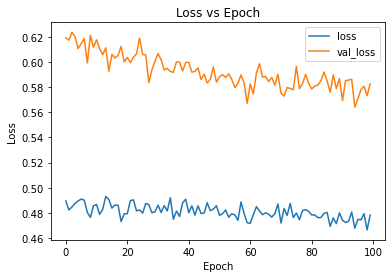

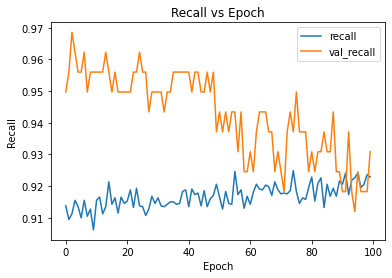

In [400]:
metrics = pd.DataFrame(history.history)
metrics[['loss', 'val_loss']].plot(title='Loss vs Epoch', xlabel='Epoch', ylabel='Loss')
metrics[['recall', 'val_recall']].plot(title='Recall vs Epoch', xlabel='Epoch', ylabel='Recall')

Dari grafik loss vs epoch untuk model sequential API didapat selisih nilai loss yang cukup jauh antara data train dengan data validation, selisih tersebut sekitar 0.20 point adapun pada grafik recall vs epoch terlihat selisih yang kecil antara nilai recall data train dan nilai recall data validation, selisih tersebut sekitar 0.01 point.

In [355]:
y_pred = model.predict(X_test_final)
y_pred = np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test, y_pred))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       776
           1       0.41      0.85      0.55       280

    accuracy                           0.63      1056
   macro avg       0.66      0.70      0.62      1056
weighted avg       0.78      0.63      0.65      1056



Didapat nilai recall untuk kelas positif = kelas 1 sebesar 0.85, artinya model berhasil memprediksi 85% customer yang churn (True Positive) dari semua customer yang churn secara real (True Positive + False Negative). Adapun nilai precision (kelas positif = kelas 1) untuk model ini cukup rendah yaitu sebesar 0.41 yang artinya dari seluruh customer yang diprediksi churn (True Positive + False Positive) hanya 41% saja yang benar-benar churn (True Positive).

### b. Functional API

<AxesSubplot:title={'center':'Recall vs Epoch'}, xlabel='Epoch', ylabel='Recall'>

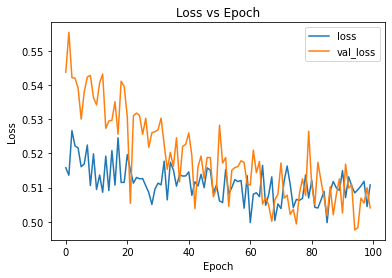

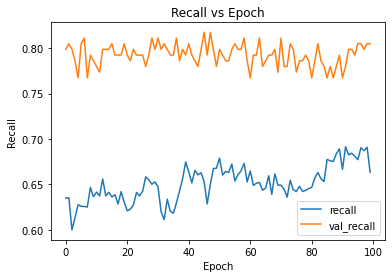

In [401]:
metrics2 = pd.DataFrame(history2.history)
metrics2[['loss', 'val_loss']].plot(title='Loss vs Epoch', xlabel='Epoch', ylabel='Loss')
metrics2[['recall', 'val_recall']].plot(title='Recall vs Epoch', xlabel='Epoch', ylabel='Recall')

Dari grafik loss vs epoch untuk model sequential API didapat selisih nilai loss yang cukup kecil antara data train dengan data validation, selisih tersebut sekitar 0.05 point adapun pada grafik recall vs epoch terlihat selisih yang besar antara nilai recall data train dan nilai recall data validation, selisih tersebut sekitar 0.15 point.

In [357]:
y_pred2 = model2.predict(X_test_final)
y_pred2 = np.where(y_pred2 >= 0.5, 1, 0)
print(classification_report(y_test, y_pred2))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       776
           1       0.48      0.77      0.59       280

    accuracy                           0.72      1056
   macro avg       0.69      0.73      0.69      1056
weighted avg       0.78      0.72      0.73      1056



Didapat nilai recall untuk kelas positif = kelas 1 sebesar 0.77, artinya model berhasil memprediksi 77% customer yang churn (True Positive) dari semua customer yang churn secara real (True Positive + False Negative). Adapun nilai precision (kelas positif = kelas 1) untuk model ini cukup rendah yaitu sebesar 0.48 yang artinya dari seluruh customer yang diprediksi churn (True Positive + False Positive) hanya 48% saja yang benar-benar churn (True Positive).

Kedua model Neural Network di atas disusun dengan arsitektur yang sama, yang berbeda hanya API-nya saja, akan tetapi keduanya menghasilkan performa yang berbeda. Hal ini dikarenakan nilai tebakan awal dari tiep-tiap model tersebut berbeda sehingga keduanya menghasilkan performa yang berbeda.

### c. Model Improvement
Dilakukan model improvement terhadap model Neural Network yang sudah dibuat yaitu dengan:
1. Mengurangi jumlah hidden layer
2. Mengubah nilai neuron pada tiap-tiap hidden layer
3. Mengubah activation function pada hidden layer

Didapatkan model Neural Network dengan arsitektur sebagai berikut :

In [391]:
model3 = Sequential()
model3.add(Dense(18, input_shape=(X_train_final.shape[1],))) # hidden layer 1
model3.add(Activation('elu'))
model3.add(Dropout(0.3))
model3.add(Dense(6)) # hidden layer 2
model3.add(Activation('elu'))
model3.add(Dropout(0.3))
model3.add(Dense(2)) # hidden layer 3
model3.add(Activation('elu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid')) # output layer

model3.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['Recall'])

Selanjutnya dilakukan training terhadap model hasil improvement menggunakan data train :

In [392]:
history3 = model3.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 0.5380 - recall: 0.6891 - val_loss: 0.9250 - val_recall: 0.9937
Epoch 2/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5505 - recall: 0.7708 - val_loss: 0.7904 - val_recall: 0.9937
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5308 - recall: 0.8007 - val_loss: 0.7651 - val_recall: 0.9874
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 0.5264 - recall: 0.8032 - val_loss: 0.7298 - val_recall: 0.9874
Epoch 5/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5234 - recall: 0.8120 - val_loss: 0.7055 - val_recall: 0.9874
Epoch 6/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5135 - recall: 0.8353 - val_loss: 0.6874 - val_recall: 0.9811
Epoch 7/100
248/248 [==============================] - 1s 3ms/step - loss: 0.5184 - recall: 0.8424 - val_loss: 0.6794 - val_recall: 0.9748
Epoch 8/100
248/248 [======

Didapatkan hasil sebagai berikut :

<AxesSubplot:title={'center':'Recall vs Epoch'}, xlabel='Epoch', ylabel='Recall'>

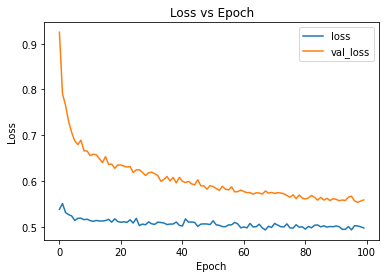

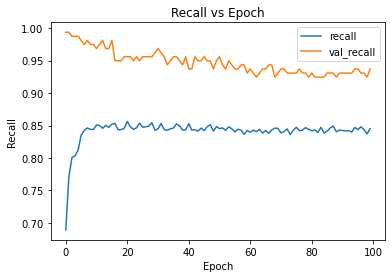

In [402]:
metrics3 = pd.DataFrame(history3.history)
metrics3[['loss', 'val_loss']].plot(title='Loss vs Epoch', xlabel='Epoch', ylabel='Loss')
metrics3[['recall', 'val_recall']].plot(title='Recall vs Epoch', xlabel='Epoch', ylabel='Recall')

Dari grafik loss vs epoch untuk model sequential API didapat selisih nilai loss yang cukup kecil antara data train dengan data validation, selisih tersebut sekitar 0.06 point adapun pada grafik recall vs epoch terlihat selisih yang besar antara nilai recall data train dan nilai recall data validation, selisih tersebut sekitar 0.1 point.

In [394]:
y_pred3 = model3.predict(X_test_final)
y_pred3 = np.where(y_pred3 >= 0.5, 1, 0)
print(classification_report(y_test, y_pred3))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       776
           1       0.44      0.88      0.59       280

    accuracy                           0.67      1056
   macro avg       0.69      0.74      0.66      1056
weighted avg       0.80      0.67      0.69      1056



Didapat nilai recall untuk kelas positif = kelas 1 sebesar 0.88, artinya model berhasil memprediksi 88% customer yang churn (True Positive) dari semua customer yang churn secara real (True Positive + False Negative). Adapun nilai precision (kelas positif = kelas 1) untuk model ini cukup rendah yaitu sebesar 0.44 yang artinya dari seluruh customer yang diprediksi churn (True Positive + False Positive) hanya 44% saja yang benar-benar churn (True Positive).

## 9. Model Saving
Pipeline preprocessing dan model Neural Network yang telah di-improve, di-save untuk di-deploy ke heroku.

In [397]:
with open("prep_pipe.pkl", "wb") as f:
    pickle.dump(prep_pipeline, f)

In [395]:
model3.save('telco_churn_model.h5')

## 10. Model Inference
Akan dilakukan prediksi terhadap data inference menggunakan model terbaik yaitu model Neural Network hasil improvement.

In [398]:
#Drop kolom yang tidak digunakan
inf_drop = df_inf.drop(['gender', 'PhoneService', 'TotalCharges', 'Churn'], axis=1)

#Inputasi Yes/No pada kolom SeniorCitizen
inf_drop['SeniorCitizen'] = inf_drop.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

#Load pipeline preprocessing
with open("prep_pipe.pkl", "rb") as f:
    prep_pipe_load = pickle.load(f)

#Lakukan transform menggunakan pipeline preprocessing
inf_prep = prep_pipe_load.transform(inf_drop)

#Load model yang telah di save
model_telco_churn = load_model("telco_churn_model.h5")

#Lakukan prediksi menggunakan model hasil improvement
inf_result = model_telco_churn.predict(inf_prep)
inf_result = np.where(inf_result>=0.5, 1, 0)

1/1 [==============================] - 0s 86ms/step


Setelah dilakukan prediksi, tampilkan hasilnya dengan data inference awal (sebelum di-preprocessing):

In [399]:
hasil = inf_drop.copy()
hasil['churn_pred'] = inf_result
hasil

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,churn_pred
0,No,Yes,Yes,18,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),24.65,0
1,No,Yes,Yes,25,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.10,0
2,No,No,Yes,1,No,DSL,Yes,Yes,No,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),70.45,1
3,No,Yes,Yes,63,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Electronic check,19.35,0
4,No,No,No,10,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.35,0


## 10. Kesimpulan
Kesimpulan yang dapat diambil dari pengerjaan tugas ini adalah :
1. Kolom yang berkorelasi dengan target untuk dataset ini adalah sebagai berikut :

    ['tenure', 'MonthlyCharges', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
     'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 
     'PaperlessBilling']

2. Metrics yang digunakan untuk mengukur bagus tidaknya model pada kasus ini adalah recall, hal ini dikarenakan model akan digunakan untuk menebak customer yang akan churn, dan customer yang diprediksi churn akan diberi promo atau tindakan khusus untuk mencegah mereka berhenti menggunakan layanan, semakin besar recall artinya semakin banyak customer yang berpotensi churn yang dapat dideteksi oleh perusahaan sehingga perusahaan dapat melakukan treatment sebelum customer tersebut benar-benar churn.

3. Treatment khusus yang diberikan perusahaan terhadap customer yang berpotensi churn pastinya akan membutuhkan beban biaya tambahan bagi perusahaan. Oleh karena itu metrics precision dapat berarti efektivitas promo yang diberikan perusahaan terhadap pelanggan yang berpotensi churn, karena precision (kelas 1) artinya adalah jumlah tebakan benar dari semua yang ditebak churn. Saya memilih menggunakan metrics recall dibandingkan precision dengan asumsi :

    a. Kondisi keuangan perusahaan baik.
    
    b. Jumlah customer yang berpotensi churn tidak terlalu banyak sehingga promo yang diberikan tidak akan membebani keuangan perusahaan.

4. Model Neural Network yang sudah di-improve memiliki nilai recall untuk kelas 1 sebesar 0.88 yang artinya 88% pelanggan yang churn berhasil diprediksi oleh model (TP/TP+FN). Namun model ini memiliki nilai precision yang cukup rendah yaitu 0.44 yang artinya dari semua pelanggan yang model prediksi akan churn hanya 44% saja yang benar-benar churn.